# Анализ лояльности пользователей Яндекс Афиши

### Цели и задачи проекта
**Цель:** Провести исследовательский анализ для Яндекс Афиши с целью понимания какие пользователи с большей вероятностью возвращаются на платформу для повторных заказов.

**Задачи:**
1. Загрузить данные и ознакомиться с ними
2. Предобработка данных
3. Провести исследовательский анализ данных
4. Формирование выводов и рекомендаций

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`:

- **Хост** — `rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net`
- **База данных** — `data-analyst-afisha`
- **Порт** — `6432`
- **Аутентификация** — `Database Native`
- **Пользователь** — `praktikum_student`
- **Пароль** — `Sdf4$2;d-d30pp`

Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


Загрузим основные библиотеки. Приконнектимся к базе данных и передадим SQL запрос. Далее выгрузим его в датафрейм `df`.

In [1]:
!pip install phik
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from sqlalchemy import create_engine 

In [2]:
db_config = {'user': 'praktikum_student', 
             'pwd': 'Sdf4$2;d-d30pp', 
             'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
             'port': 6432, 
             'db': 'data-analyst-afisha'
             }

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

engine = create_engine(connection_string) 

In [3]:
query = '''
SELECT p.user_id,
       p.device_type_canonical,
       p.order_id,
       p.created_dt_msk AS order_dt,
       p.created_ts_msk AS order_ts,
       p.currency_code,
       p.revenue,
       p.tickets_count,
       EXTRACT(DAY FROM(created_dt_msk - LAG(created_dt_msk) OVER (PARTITION BY user_id ORDER BY created_dt_msk))) AS days_since_prev, 
       e.event_id,
       e.event_name_code AS event_name,
       p.service_name,
       e.event_type_main,
       r.region_name,
       c.city_name
FROM afisha.purchases AS p
INNER JOIN afisha.events AS e ON e.event_id = p.event_id
INNER JOIN afisha.city AS c ON c.city_id = e.city_id
INNER join afisha.regions AS r ON r.region_id = c.region_id
WHERE (p.device_type_canonical = 'mobile' OR p.device_type_canonical = 'desktop') AND event_type_main != 'фильм'
ORDER BY p.user_id;
'''

In [4]:
df = pd.read_sql_query(query, con=engine) 

---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

Выведем информацию о датафрейме:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  service_name           290611 non-null  object        
 12  event_type_main        290611 non-null  obje

In [6]:
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,service_name,event_type_main,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,Край билетов,театр,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,Мой билет,выставки,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,За билетом!,другое,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,Лови билет!,другое,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,Билеты без проблем,стендап,Озернинский край,Родниковецк


#### Промежуточный вывод:
Датафрейм `df` содержит:
1. Количество строк - 290611. Количество столбцов - 15;
2. Пропуски встречаются только в столбце `days_since_prev` это обусловлено тем, что это могут быть новые пользователи платформы и у них нет предыдущих заказов;
3. Тип `object` у колонок: `user_id`, `device_type_canonical`, `currency_code`, `event_name`, `service_name`, `event_type_main`, `region_name` и `city_name`;
4. Тип `int64` у колонок: `order_id`, `tickets_count` и `event_id`;
5. Тип `float64` у колонок: `revenue` и `days_since_prev`;
6. Тип `datetime64[ns]` у колонок: `order_dt` и `order_ts`.



---

###  2. Предобработка данных

Выполним предобработку данных:




---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---

Объединим два датафрейма в один:

In [7]:
df_exchange = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')
df_exchange.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [8]:
df_exchange['data'] = pd.to_datetime(df_exchange['data'])
df_merged = df.merge(df_exchange, left_on=['order_dt'], right_on = ['data'], how='inner')

In [9]:
df_merged.loc[df_merged['currency_code'] == 'kzt', 'revenue_rub'] = ((df_merged['revenue'] / 100) * df_merged['curs'])
df_merged.loc[df_merged['currency_code'] != 'kzt', 'revenue_rub'] = df_merged['revenue']

Удалим ненужные столбцы:

In [10]:
columns_to_drop = ['data','curs','nominal','cdx']
df_merged = df_merged.drop(columns = columns_to_drop)
df_merged.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,service_name,event_type_main,region_name,city_name,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,Край билетов,театр,Каменевский регион,Глиногорск,1521.94
1,002bf837be989ea,mobile,2543446,2024-08-20,2024-08-20 16:52:43,rub,1503.25,4,NaN,453660,ef3f74ed-6c81-453a-9499-97d8735a0f94,Билеты без проблем,концерты,Боровлянский край,Каменский,1503.25
2,008e87176c21913,mobile,1955732,2024-08-20,2024-08-20 14:34:59,rub,39.72,2,NaN,211375,06ae0e6c-cb45-4b2c-a681-787d2c7b9a47,Лучшие билеты,другое,Широковская область,Радужнополье,39.72
3,00ac6ea01bf4b8b,mobile,8614364,2024-08-20,2024-08-20 17:27:10,rub,204.76,3,5.0,552779,146324a1-9190-4c64-bf37-f3b41ca730b3,Мой билет,концерты,Широковская область,Луговаярово,204.76
4,010ff037253e138,desktop,181947,2024-08-20,2024-08-20 16:01:51,rub,1550.40,4,NaN,508859,cb3759d1-9b7a-4e3e-b0de-24cdfd4424e5,Яблоко,концерты,Травиницкий округ,Сосновечин,1550.40


Получили интересующий нас датафрейм.

---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

Выведем типы столбцов:

In [11]:
df_merged.dtypes

user_id                          object
device_type_canonical            object
order_id                          int64
order_dt                 datetime64[ns]
order_ts                 datetime64[ns]
currency_code                    object
revenue                         float64
tickets_count                     int64
days_since_prev                 float64
event_id                          int64
event_name                       object
service_name                     object
event_type_main                  object
region_name                      object
city_name                        object
revenue_rub                     float64
dtype: object

Узнаем количество пропусков в датафрейме:

In [12]:
df_merged.isna().sum()

user_id                      0
device_type_canonical        0
order_id                     0
order_dt                     0
order_ts                     0
currency_code                0
revenue                      0
tickets_count                0
days_since_prev          21933
event_id                     0
event_name                   0
service_name                 0
event_type_main              0
region_name                  0
city_name                    0
revenue_rub                  0
dtype: int64

In [13]:
df_merged.isna().mean()

user_id                  0.000000
device_type_canonical    0.000000
order_id                 0.000000
order_dt                 0.000000
order_ts                 0.000000
currency_code            0.000000
revenue                  0.000000
tickets_count            0.000000
days_since_prev          0.075472
event_id                 0.000000
event_name               0.000000
service_name             0.000000
event_type_main          0.000000
region_name              0.000000
city_name                0.000000
dtype: float64

Пропуски есть только в столбце `days_since_prev` это обусловлено тем, что пользователи на платформе раньше не бронировали билеты.
Количество пропусков - 21 933. 

Доля пропусков 7.5%.

Проверим данные на явные и неявные дубликаты:

In [14]:
df_merged.duplicated().sum()

0

Проверим данные на дубликаты в столбце `order_id`:

In [15]:
df_merged.duplicated(subset='order_id').sum()

0

Приведем данные в столбцах `service_name`, `event_type_main`, `region_name` и `city_name` к `snake_case` чтобы исключить неявные дубликаты.

In [16]:
columns_to_convert = ['service_name', 'event_type_main', 'region_name', 'city_name']
for col in columns_to_convert:
    df_merged[col] = df_merged[col].str.lower().str.replace(' ', '_')
df_merged.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,service_name,event_type_main,region_name,city_name,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,край_билетов,театр,каменевский_регион,глиногорск,1521.94
1,002bf837be989ea,mobile,2543446,2024-08-20,2024-08-20 16:52:43,rub,1503.25,4,NaN,453660,ef3f74ed-6c81-453a-9499-97d8735a0f94,билеты_без_проблем,концерты,боровлянский_край,каменский,1503.25
2,008e87176c21913,mobile,1955732,2024-08-20,2024-08-20 14:34:59,rub,39.72,2,NaN,211375,06ae0e6c-cb45-4b2c-a681-787d2c7b9a47,лучшие_билеты,другое,широковская_область,радужнополье,39.72
3,00ac6ea01bf4b8b,mobile,8614364,2024-08-20,2024-08-20 17:27:10,rub,204.76,3,5.0,552779,146324a1-9190-4c64-bf37-f3b41ca730b3,мой_билет,концерты,широковская_область,луговаярово,204.76
4,010ff037253e138,desktop,181947,2024-08-20,2024-08-20 16:01:51,rub,1550.40,4,NaN,508859,cb3759d1-9b7a-4e3e-b0de-24cdfd4424e5,яблоко,концерты,травиницкий_округ,сосновечин,1550.40


In [17]:
df_merged.duplicated().sum()

0

После предобработки данных не было обнаружено явных и неявных дубликатов.

Проверим уникальные значения категориальных данных:

In [18]:
for column in ['service_name', 'event_type_main','region_name', 'city_name','currency_code']:
    np.set_printoptions(threshold=np.inf) 
    print(f'Уникальные значения в столбце {column}:')
    print(df_merged[column].sort_values().unique())
    print()

Уникальные значения в столбце service_name:
['crazy_ticket!' 'show_ticket' 'билет_по_телефону' 'билеты_без_проблем'
 'билеты_в_интернете' 'билеты_в_руки' 'быстробилет' 'быстрый_кассир'
 'весь_в_билетах' 'восьмёрка' 'вперёд!' 'выступления.ру'
 'городской_дом_культуры' 'дом_культуры' 'дырокол' 'за_билетом!'
 'зе_бест!' 'карандашру' 'кино_билет' 'край_билетов' 'лимоны'
 'лови_билет!' 'лучшие_билеты' 'мир_касс' 'мой_билет' 'облачко'
 'прачечная' 'радио_ticket' 'реестр' 'росбилет' 'тебе_билет!' 'телебилет'
 'тех_билет' 'цвет_и_билет' 'шоу_начинается!' 'яблоко']

Уникальные значения в столбце event_type_main:
['выставки' 'другое' 'концерты' 'спорт' 'стендап' 'театр' 'ёлки']

Уникальные значения в столбце region_name:
['белоярская_область' 'берестовский_округ' 'берёзовская_область'
 'боровлянский_край' 'верховинская_область' 'верхозёрский_край'
 'верхоречная_область' 'ветренский_регион' 'вишнёвский_край'
 'глиногорская_область' 'голубевский_округ' 'горицветская_область'
 'горноземский_регион'

Сделаем оптимизацию датафрейма:

In [19]:
df_optimazed = df_merged.copy()
columns_to_astype = ['device_type_canonical' , 'currency_code','event_type_main']
for col in columns_to_astype:
    df_optimazed[col] = df_optimazed[col].astype('category')
    
df_optimazed['tickets_count'] = df_optimazed['tickets_count'].astype('int8')

df_optimazed['days_since_prev'] = df_optimazed['days_since_prev'].fillna(-1)
df_optimazed['days_since_prev'] = df_optimazed['days_since_prev'].astype('int16')
df_optimazed.dtypes

user_id                          object
device_type_canonical          category
order_id                          int64
order_dt                 datetime64[ns]
order_ts                 datetime64[ns]
currency_code                  category
revenue                         float64
tickets_count                      int8
days_since_prev                   int16
event_id                          int64
event_name                       object
service_name                     object
event_type_main                category
region_name                      object
city_name                        object
revenue_rub                     float64
dtype: object

Проверим распределение численных данных и наличие в них выбросов в столбцах `revenue_rub` и `tickets_count`:

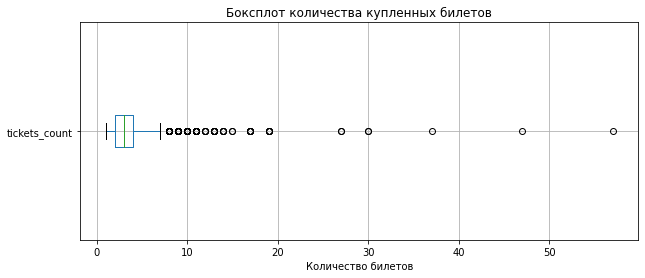

In [20]:
plt.figure(figsize=(10,4))
df_optimazed.boxplot(column='tickets_count', vert=False)
plt.title('Боксплот количества купленных билетов')
plt.xlabel('Количество билетов')
plt.ylabel('')
plt.show()

Присутствуют выбросы количества билетов на боксплоте. Это может быть обусловлено ошибкой в данных или покупокой билетов на большое количество людей.

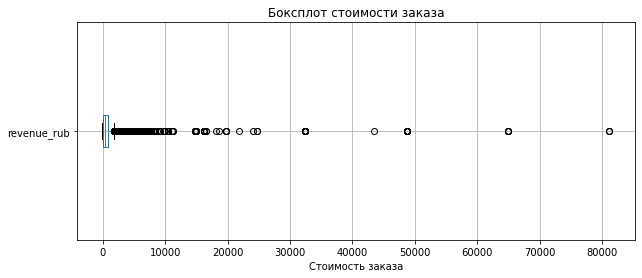

In [21]:
plt.figure(figsize=(10,4))
df_optimazed.boxplot(column='revenue_rub', vert=False)
plt.title('Боксплот стоимости заказа')
plt.xlabel('Стоимость заказа')
plt.ylabel('')
plt.show()

Выбросы в стоимости заказа могут быть обусловлены ошибкой в данных или это заказ на большое количество людей.

In [22]:
q99 = df_optimazed['revenue_rub'].quantile(0.99)
df_filtered = df_optimazed[df_optimazed['revenue_rub'] <= q99].copy()
print(f"Удалено {len(df_optimazed) - len(df_filtered)} строк или {(1 - len(df_filtered)/len(df_optimazed))*100:.2f}%")

Удалено 2825 строк или 0.97%


**Промежуточный вывод:**

Добавили новый столбец `revenue_rub` в котором все данные со столбца `revenue` приведены к рублям.

После предобработки не было выявлено явных и неявных дубликатов. Также вывели все уникальные значения в категориальных столбцах.

Заменили пропуски в столбце `days_since_prev` на `-1`.

Оптимизировали типы данных в датафрейме.

Выявили выбросы в интересующих нас столбцах `revenue_rub` и `tickets_count`. Отфильтровали датафрейм по 99 процентилю по столбцу `revenue_rub`. 

Датафрейм уменьшился на 2825 строк или на 0.97%.

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [23]:
df_filtered = df_filtered.sort_values('order_ts')

In [24]:
user_profiles = df_filtered.groupby('user_id').agg(
    first_order = ('order_dt', 'min'),
    last_order = ('order_dt', 'max'),
    device = ('device_type_canonical', 'first'),
    region = ('region_name', 'first'),
    service_name = ('service_name', 'first'),
    genre_event = ('event_type_main', 'first'),
    total_orders = ('order_id', 'size'),
    avg_order_costs = ('revenue_rub', 'mean'),
    avg_tickets_count=('tickets_count', 'mean'),
    avg_days_since_prev = ('days_since_prev', 'mean')
).reset_index()
user_profiles['is_two'] = user_profiles['total_orders'] >= 2
user_profiles['is_five'] = user_profiles['total_orders'] >=5

user_profiles['avg_order_costs'] = user_profiles['avg_order_costs'].round(2)
user_profiles['avg_tickets_count'] = user_profiles['avg_tickets_count'].round(2)
user_profiles['avg_days_since_prev'] = user_profiles['avg_days_since_prev'].round(2)

user_profiles.head()

,user_id,first_order,last_order,device,region,service_name,genre_event,total_orders,avg_order_costs,avg_tickets_count,avg_days_since_prev,is_two,is_five
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,каменевский_регион,край_билетов,театр,1,1521.94,4.00,-1.00,False,False
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,каменевский_регион,мой_билет,выставки,2,774.01,3.00,37.00,True,False
2,000898990054619,2024-07-13,2024-10-23,mobile,североярская_область,лови_билет!,другое,3,767.21,2.67,33.67,True,False
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,каменевский_регион,край_билетов,театр,1,917.83,4.00,-1.00,False,False
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,поленовский_край,лучшие_билеты,театр,2,61.31,1.50,7.50,True,False


Профиль пользователя создан.

---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [25]:
total_users = user_profiles['user_id'].agg('size')
print('Общее количество пользователей в выборке:', total_users)
print('Средняя выручка с одного заказа в рублях:', user_profiles['avg_order_costs'].mean().round(2))
print('Доля пользователей, совершивших 2 и более заказа:', ((user_profiles['is_two'].sum() / total_users)*100).round(2)) 
print('Доля пользователей, совершивших 5 и более заказов:', ((user_profiles['is_five'].sum() / total_users)*100).round(2))

Общее количество пользователей в выборке: 21854
Средняя выручка с одного заказа в рублях: 544.4
Доля пользователей, совершивших 2 и более заказа: 61.71
Доля пользователей, совершивших 5 и более заказов: 29.01


In [26]:
print('Статистика по общему числу заказов:', user_profiles['total_orders'].describe())
print('Статистика по среднему числу билетов в заказе:', user_profiles['avg_tickets_count'].describe())
filtered_days = user_profiles[user_profiles['avg_days_since_prev'] >= 0]['avg_days_since_prev']
print('Статистика по среднему количеству дней между покупками:', filtered_days.describe())

Статистика по общему числу заказов: count    21854.000000
mean        13.168573
std        121.674800
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max      10181.000000
Name: total_orders, dtype: float64
Статистика по среднему числу билетов в заказе: count    21854.000000
mean         2.743136
std          0.913090
min          1.000000
25%          2.000000
50%          2.750000
75%          3.080000
max         11.000000
Name: avg_tickets_count, dtype: float64
Статистика по среднему количеству дней между покупками: count    10793.000000
mean        13.043042
std         12.620220
min          0.000000
25%          4.000000
50%          9.330000
75%         17.830000
max        137.000000
Name: avg_days_since_prev, dtype: float64


После сбора статистики по столбцам `total_orders`, `avg_tickets_count` и `avg_days_since_prev` выявили выбросы в столбце `total_orders`. Максимальное значение в стоблце `total_orders` составляет 10181, это может быть обусловлено ошибкой в данных, аномалий или это корпоративный аккаунт.

Визуализируем статистику по каждому столбцу:

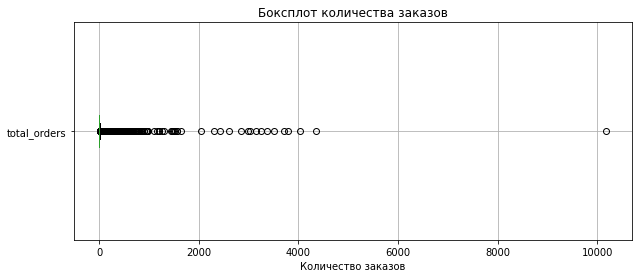

In [27]:
plt.figure(figsize=(10,4))
user_profiles.boxplot(column='total_orders', vert=False)
plt.title('Боксплот количества заказов')
plt.xlabel('Количество заказов')
plt.ylabel('')
plt.show()

Ярко выражен выброс.

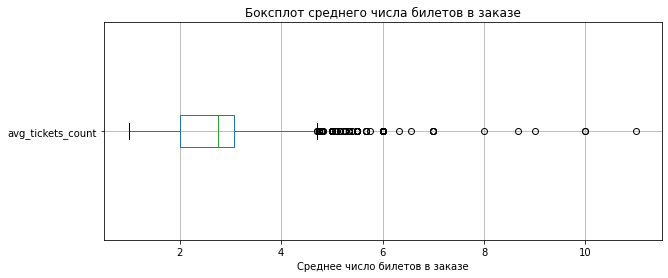

In [28]:
plt.figure(figsize=(10,4))
user_profiles.boxplot(column='avg_tickets_count', vert=False)
plt.title('Боксплот среднего числа билетов в заказе')
plt.xlabel('Среднее число билетов в заказе')
plt.ylabel('')
plt.show()

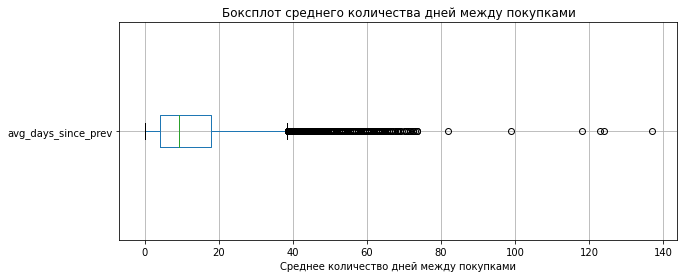

In [29]:
filtered_days_df = user_profiles[user_profiles['avg_days_since_prev'] >= 0]
plt.figure(figsize=(10,4))
filtered_days_df.boxplot(column='avg_days_since_prev', vert=False)
plt.title('Боксплот среднего количества дней между покупками')
plt.xlabel('Среднее количество дней между покупками')
plt.ylabel('')
plt.show()

Отфильтруем данные в столбце `total_orders` по 99 процентилю, чтобы оставить больше рабочих данных.

In [30]:
total_orders = user_profiles['total_orders'].quantile(0.99)
user_profiles_filtered = user_profiles[user_profiles['total_orders'] <= total_orders].copy()

original = len(user_profiles)
filtered = len(user_profiles_filtered)
removed = original - filtered
print(f"Оригинальный датасет: {original} пользователей")
print(f"После фильтрации: {filtered} пользователей")
print(f"Отфильтровано: {removed} пользователей ({removed / original * 100:.2f}%)")

Оригинальный датасет: 21854 пользователей
После фильтрации: 21638 пользователей
Отфильтровано: 216 пользователей (0.99%)


In [31]:
print('Статистика по общему числу заказов:', user_profiles_filtered['total_orders'].describe())
print('Статистика по среднему числу билетов в заказе:', user_profiles_filtered['avg_tickets_count'].describe())
filtered_days = user_profiles_filtered[user_profiles_filtered['avg_days_since_prev'] >= 0]['avg_days_since_prev']
print('Статистика по среднему количеству дней между покупками:', filtered_days.describe())

Статистика по общему числу заказов: count    21638.000000
mean         6.501294
std         14.324031
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        152.000000
Name: total_orders, dtype: float64
Статистика по среднему числу билетов в заказе: count    21638.000000
mean         2.743327
std          0.917496
min          1.000000
25%          2.000000
50%          2.750000
75%          3.100000
max         11.000000
Name: avg_tickets_count, dtype: float64
Статистика по среднему количеству дней между покупками: count    10577.000000
mean        13.300133
std         12.618175
min          0.000000
25%          4.400000
50%          9.620000
75%         18.000000
max        137.000000
Name: avg_days_since_prev, dtype: float64


---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [32]:
segment_event_type = user_profiles_filtered.groupby('genre_event')['user_id'].agg('count').reset_index(name = 'user_count')
segment_event_type['share'] = (segment_event_type['user_count'] / segment_event_type['user_count'].sum()).round(2)
print(segment_event_type.sort_values('user_count', ascending=False))

  genre_event  user_count  share
2    концерты        9560   0.44
1      другое        5426   0.25
5       театр        4239   0.20
4     стендап        1110   0.05
3       спорт         794   0.04
0    выставки         414   0.02
6        ёлки          95   0.00


In [33]:
segment_device_type = user_profiles_filtered.groupby('device')['user_id'].agg('count').reset_index(name = 'user_count')
segment_device_type['share'] = (segment_device_type['user_count'] / segment_device_type['user_count'].sum()).round(2)
print(segment_device_type.sort_values('user_count', ascending=False))

    device  user_count  share
1   mobile       17924   0.83
0  desktop        3714   0.17


In [34]:
segment_region_type = user_profiles_filtered.groupby('region')['user_id'].agg('count').reset_index(name = 'user_count')
segment_region_type['share'] = (segment_region_type['user_count'] / segment_region_type['user_count'].sum()).round(2)
print(segment_region_type.sort_values('user_count', ascending=False))

                      region  user_count  share
23        каменевский_регион        7085   0.33
60      североярская_область        3767   0.17
77       широковская_область        1224   0.06
45          озернинский_край         675   0.03
41      малиновоярский_округ         525   0.02
..                       ...         ...    ...
17            залесский_край           2   0.00
70       тихогорская_область           2   0.00
5          верхозёрский_край           1   0.00
66  сосноводолинская_область           1   0.00
80        яснопольский_округ           1   0.00

[81 rows x 3 columns]


In [35]:
segment_service_name_type = user_profiles_filtered.groupby('service_name')['user_id'].agg('count').reset_index(name = 'user_count')
segment_service_name_type['share'] = (segment_service_name_type['user_count'] / segment_service_name_type['user_count'].sum()).round(2)
print(segment_service_name_type.sort_values('user_count', ascending=False))

              service_name  user_count  share
3       билеты_без_проблем        5186   0.24
22               мой_билет        2969   0.14
19             лови_билет!        2809   0.13
4            билеты_в_руки        2559   0.12
23                 облачко        2177   0.10
7           весь_в_билетах        1285   0.06
20           лучшие_билеты        1184   0.05
24               прачечная         583   0.03
17            край_билетов         454   0.02
12            дом_культуры         356   0.02
33                  яблоко         318   0.01
28             тебе_билет!         308   0.01
11  городской_дом_культуры         215   0.01
21                мир_касс         209   0.01
13             за_билетом!         201   0.01
5              быстробилет         162   0.01
1              show_ticket         157   0.01
10          выступления.ру          95   0.00
8                восьмёрка          85   0.00
6           быстрый_кассир          61   0.00
0            crazy_ticket!        

Промежуточный вывод:
1. Сегмент по типу ивентов - на `концерты` покупают билеты наибольшее количество пользователей (9560 человек или 0.44 от всего количества пользователей) чем на другие ивенты.
2. Сегмент по региону - `каменевский_регион` наиболее популярный у пользователей, 7085 пользователей или 0.33 от всего количества пользователей. Возможно, что наибольшее количество ивентов проводятся именно в этом регионе.
3. Сегмент по типу девайса - количество заказов совершенный через мобильное устройство намного больше чем с десктопного, 17924 человек или 0.83 от всего количества пользователей.
4. Сегмен по типу сервиса - наибольшее количество пользователей приобрели билеты через сервис `билеты_без_проблем`, 5186 человек или 0.24 от всего количества пользователей.

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


  genre_event  user_count  share
2    концерты        5911   0.45
1      другое        3235   0.24
5       театр        2687   0.20
4     стендап         676   0.05
3       спорт         443   0.03
0    выставки         265   0.02
6        ёлки          53   0.00


<Figure size 1008x576 with 0 Axes>

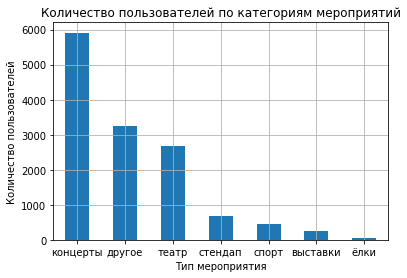

In [36]:
filtered_is_two = user_profiles_filtered[user_profiles_filtered['is_two'] == True]
segment_event_type = filtered_is_two.groupby('genre_event')['user_id'].agg('count').reset_index(name = 'user_count')
segment_event_type['share'] = (segment_event_type['user_count'] / segment_event_type['user_count'].sum()).round(2)
segment_event_type_sorted = segment_event_type.sort_values('user_count', ascending=False)
print(segment_event_type_sorted)


plt.figure(figsize=(14,8))

segment_event_type_sorted.plot(
               x = 'genre_event',
               y = 'user_count',
               kind='bar',
               rot=0,
               legend=False,
               title=f'Количество пользователей по категориям мероприятий')

plt.xlabel('Тип мероприятия')
plt.ylabel('Количество пользователей')
plt.grid()
plt.show()

    device  user_count  share
1   mobile       10900   0.82
0  desktop        2370   0.18


<Figure size 1008x576 with 0 Axes>

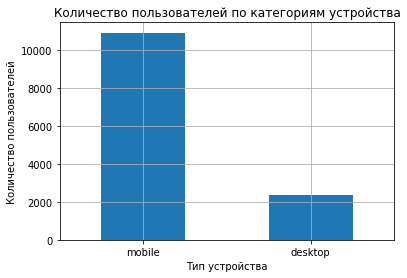

In [37]:
segment_device_type = filtered_is_two.groupby('device')['user_id'].agg('count').reset_index(name = 'user_count')
segment_device_type['share'] = (segment_device_type['user_count'] / segment_device_type['user_count'].sum()).round(2)
segment_device_type_sorted = segment_device_type.sort_values('user_count', ascending=False)
print(segment_device_type_sorted)

plt.figure(figsize=(14,8))

segment_device_type_sorted.plot(
               x = 'device',
               y = 'user_count',
               kind='bar',
               rot=0,
               legend=False,
               title=f'Количество пользователей по категориям устройства')

plt.xlabel('Тип устройства')
plt.ylabel('Количество пользователей')
plt.grid()
plt.show()

                  region  user_count  share
23    каменевский_регион        4421   0.33
60  североярская_область        2404   0.18
76   широковская_область         790   0.06
45      озернинский_край         373   0.03
75      шанырский_регион         336   0.03
..                   ...         ...    ...
67   теплоозёрский_округ           1   0.00
56     светолесский_край           1   0.00
32   крутоводский_регион           1   0.00
5      верхозёрский_край           1   0.00
17        залесский_край           1   0.00

[79 rows x 3 columns]


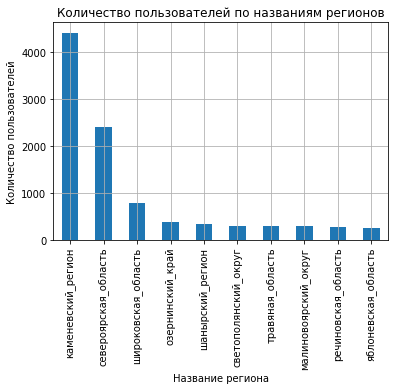

In [38]:
segment_region_type = filtered_is_two.groupby('region')['user_id'].agg('count').reset_index(name = 'user_count')
segment_region_type['share'] = (segment_region_type['user_count'] / segment_region_type['user_count'].sum()).round(2)
segment_region_type_sorted = segment_region_type.sort_values('user_count', ascending=False)
print(segment_region_type_sorted)

segment_region_type_sorted.head(10).plot(
               x = 'region',
               y = 'user_count',
               kind='bar',
               rot=90,
               legend=False,
               title=f'Количество пользователей по названиям регионов')

plt.xlabel('Название региона')
plt.ylabel('Количество пользователей')
plt.grid()
plt.show()

              service_name  user_count  share
3       билеты_без_проблем        3133   0.24
22               мой_билет        1807   0.14
19             лови_билет!        1711   0.13
4            билеты_в_руки        1605   0.12
23                 облачко        1334   0.10
7           весь_в_билетах         808   0.06
20           лучшие_билеты         725   0.05
24               прачечная         365   0.03
17            край_билетов         296   0.02
12            дом_культуры         230   0.02
28             тебе_билет!         186   0.01
33                  яблоко         170   0.01
21                мир_касс         135   0.01
11  городской_дом_культуры         126   0.01
13             за_билетом!         118   0.01
1              show_ticket         102   0.01
5              быстробилет          96   0.01
10          выступления.ру          59   0.00
8                восьмёрка          58   0.00
6           быстрый_кассир          52   0.00
0            crazy_ticket!        

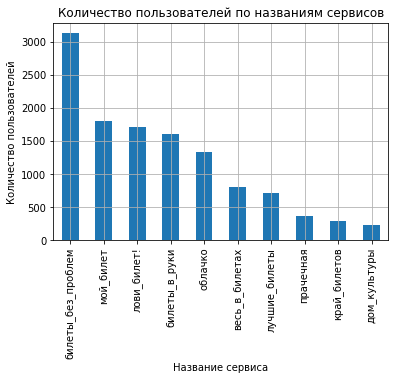

In [39]:
segment_service_name_type = filtered_is_two.groupby('service_name')['user_id'].agg('count').reset_index(name = 'user_count')
segment_service_name_type['share'] = (segment_service_name_type['user_count'] / segment_service_name_type['user_count'].sum()).round(2)
segment_service_name_type_sorted = segment_service_name_type.sort_values('user_count', ascending=False)
print(segment_service_name_type_sorted)


segment_service_name_type_sorted.head(10).plot(
               x = 'service_name',
               y = 'user_count',
               kind='bar',
               rot=90,
               legend=False,
               title=f'Количество пользователей по названиям сервисов')

plt.xlabel('Название сервиса')
plt.ylabel('Количество пользователей')
plt.grid()
plt.show()

Чаще всего пользователи которые возвращаюся на платформу Яндекс Афиша:
1. Делают заказы через `мобильное приложение`.
2. Используют сервис `билеты_без_проблем`.
3. Место проведения мероприятия в `каменевский_регион`.
4. Выбирают тип мероприятия `концерты`.

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

Проверим первую гипотезу.

<Figure size 1008x576 with 0 Axes>

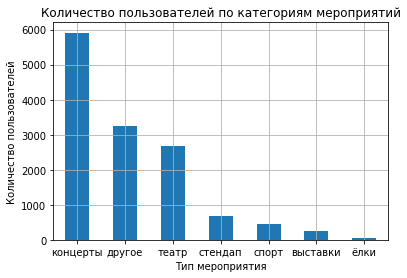

In [40]:
plt.figure(figsize=(14,8))

segment_event_type_sorted.plot(
               x = 'genre_event',
               y = 'user_count',
               kind='bar',
               rot=0,
               legend=False,
               title=f'Количество пользователей по категориям мероприятий')

plt.xlabel('Тип мероприятия')
plt.ylabel('Количество пользователей')
plt.grid()
plt.show()

Пользователи которые сделали свой первый заказ на `концерты` возвращаются на платформу чаще чем пользователи выбравшие для первого раза `спортивные` мероприятия. Гипотеза неверна.

Проверим вторую гипотезу.

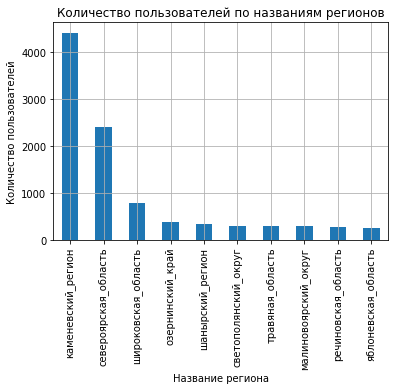

In [41]:
segment_region_type_sorted.head(10).plot(
               x = 'region',
               y = 'user_count',
               kind='bar',
               rot=90,
               legend=False,
               title=f'Количество пользователей по названиям регионов')

plt.xlabel('Название региона')
plt.ylabel('Количество пользователей')
plt.grid()
plt.show()

Гипотеза верна.

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


In [42]:
filtered_is_two = user_profiles_filtered[user_profiles_filtered['is_two'] == True]
filtered_is_one = user_profiles_filtered[user_profiles_filtered['is_two'] == False]

grouped_is_two = filtered_is_two.groupby('service_name')['avg_order_costs'].agg('mean')
grouped_is_one = filtered_is_one.groupby('service_name')['avg_order_costs'].agg('mean')

print("Группа is_two = False:")
print(grouped_is_one.describe())

print("\nГруппа is_two = True:")
print(grouped_is_two.describe())

Группа is_two = False:
count      33.000000
mean      614.251941
std       308.980447
min        29.850000
25%       369.792558
50%       660.122000
75%       809.529394
max      1206.705385
Name: avg_order_costs, dtype: float64

Группа is_two = True:
count     34.000000
mean     603.488458
std      186.918777
min       16.170000
25%      503.847372
50%      619.099839
75%      719.275290
max      914.340385
Name: avg_order_costs, dtype: float64


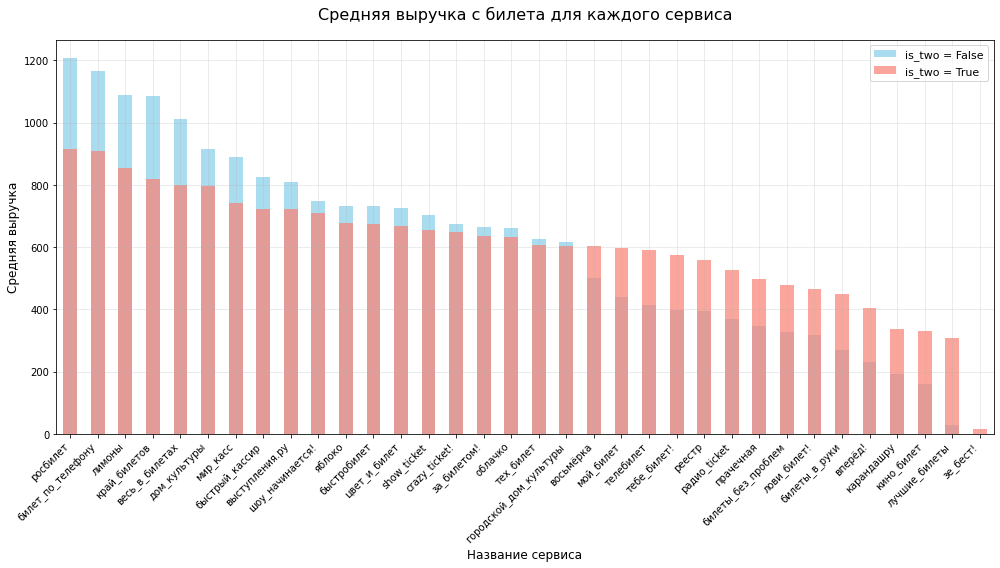

In [43]:
fig, ax = plt.subplots(figsize=(14, 8))
grouped_is_one.sort_values(ascending=False).plot(
    kind='bar',
    ax=ax,
    alpha=0.7,
    color='skyblue',
    label='is_two = False'
)

grouped_is_two.sort_values(ascending=False).plot(
    kind='bar',
    ax=ax,
    alpha=0.7,
    color='salmon',
    label='is_two = True'
)

ax.set_title('Средняя выручка с билета для каждого сервиса', fontsize=16, pad=20)
ax.set_xlabel('Название сервиса', fontsize=12)
ax.set_ylabel('Средняя выручка', fontsize=12)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)

plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

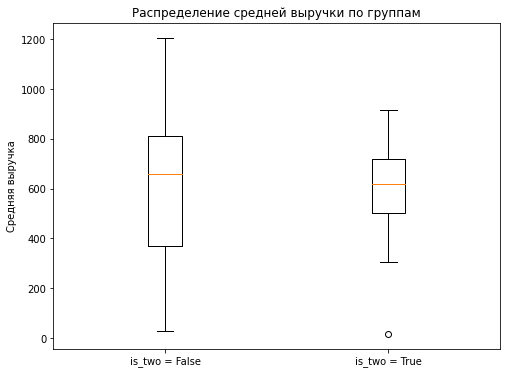

In [44]:
plt.figure(figsize=(8, 6))
plt.boxplot([grouped_is_one, grouped_is_two], labels=['is_two = False', 'is_two = True'])
plt.title('Распределение средней выручки по группам')
plt.ylabel('Средняя выручка')
plt.show()

Пользователи совершившие один заказ концентрируются в интервале от 400 до 800 рублей за заказ.
Пользователи совершившие более 1 заказа концентрируются в интервале от 500 до 700 рублей за заказ.

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


In [45]:
filtered_2_4 = user_profiles_filtered[(user_profiles_filtered['is_two'] == True) & (user_profiles_filtered['is_five'] == False)]
filtered_5 = user_profiles_filtered[user_profiles_filtered['is_five'] == True]

grouped_2_4 = filtered_2_4.groupby('service_name')['avg_order_costs'].agg('mean')
grouped_5 = filtered_5.groupby('service_name')['avg_order_costs'].agg('mean')

print("Группа is_two = False:")
print(grouped_2_4.describe())

print("\nГруппа is_two = True:")
print(grouped_5.describe())

Группа is_two = False:
count     33.000000
mean     616.801843
std      219.908080
min       16.170000
25%      468.095505
50%      628.769167
75%      720.982000
max      999.259333
Name: avg_order_costs, dtype: float64

Группа is_two = True:
count     31.000000
mean     601.118802
std      110.202808
min      344.375000
25%      546.794684
50%      595.262759
75%      651.728487
max      853.480000
Name: avg_order_costs, dtype: float64


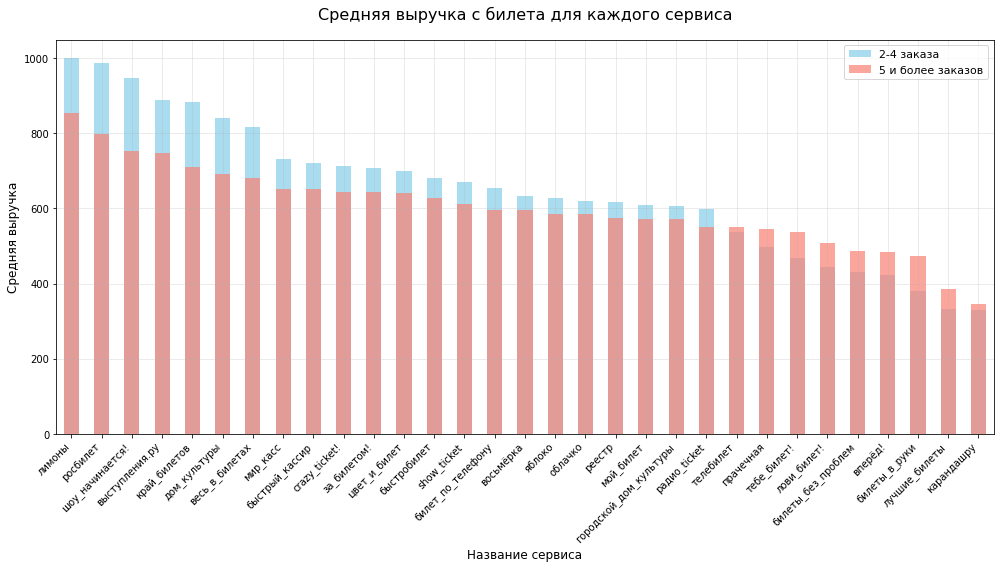

In [46]:
fig, ax = plt.subplots(figsize=(14, 8))
grouped_2_4.sort_values(ascending=False).plot(
    kind='bar',
    ax=ax,
    alpha=0.7,
    color='skyblue',
    label='2-4 заказа'
)

grouped_5.sort_values(ascending=False).plot(
    kind='bar',
    ax=ax,
    alpha=0.7,
    color='salmon',
    label='5 и более заказов'
)

ax.set_title('Средняя выручка с билета для каждого сервиса', fontsize=16, pad=20)
ax.set_xlabel('Название сервиса', fontsize=12)
ax.set_ylabel('Средняя выручка', fontsize=12)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)

plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

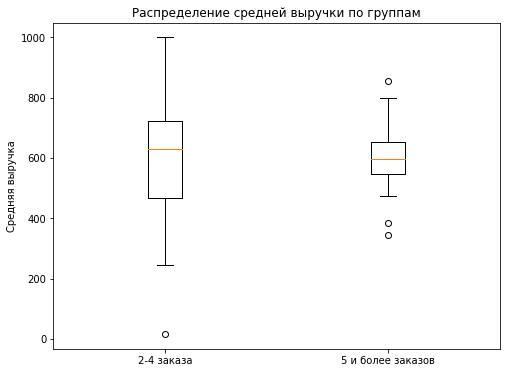

In [47]:
plt.figure(figsize=(8, 6))
plt.boxplot([grouped_2_4, grouped_5], labels=['2-4 заказа', '5 и более заказов'])
plt.title('Распределение средней выручки по группам')
plt.ylabel('Средняя выручка')
plt.show()

Пользователи группы 2-4 заказа концентрируются в интервале от 470 до 700 рублей за заказ.
Пользователи группы 5 и более заказов концентрирубтся в интервале от 550 до 650 рублей за заказ.

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

In [48]:
grouped_tickets = user_profiles_filtered.groupby('avg_tickets_count')['user_id'].agg('count')
grouped_tickets.sort_values(ascending = False).head(10)

avg_tickets_count
3.00    4178
2.00    3741
4.00    2043
1.00    1338
2.50    1155
3.50     665
2.67     544
5.00     467
2.33     460
1.50     426
Name: user_id, dtype: int64

Наибольшее количество пользователей имеют в среднем 3 билета в заказе 4178 юзера, далее следуют те у кого в среднем 2 билета в заказе 3741 юзер.

In [49]:
def segmentation(avg_tickets_count):
    if 1 <= avg_tickets_count < 2:
        return 'от 1 до 2 билетов'
    elif 2 <= avg_tickets_count < 3:
        return 'от 2 до 3 билетов'
    elif 3 <= avg_tickets_count < 5:
        return 'от 3 до 5 билетов'
    else:
        return 'от 5 и более билетов'
    
user_profiles_filtered['segment'] = user_profiles_filtered['avg_tickets_count'].apply(segmentation)
grouped_segment = user_profiles_filtered.groupby('segment').agg(total_users = ('user_id','count'), repeat_users = ('is_two','sum')).reset_index()
grouped_segment['repeat_rate'] = (grouped_segment['repeat_users'] / grouped_segment['total_users']).round(2)
grouped_segment

,segment,total_users,repeat_users,repeat_rate
0,от 1 до 2 билетов,2419,1241,0.51
1,от 2 до 3 билетов,9498,6989,0.74
2,от 3 до 5 билетов,9060,4916,0.54
3,от 5 и более билетов,661,124,0.19


Сегменты `от 1 до 2 билетов` и `от 3 до 5 билетов` имеют приблизительно равные доли пользователей совершивших повторный заказ. Сегмент `от 2 до 3 билетов` имеет наибольшую долю пользователей совершивших повторный заказ. Наименьшая доля у сегмента `от 5 и более билетов`.

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


In [50]:
user_profiles_filtered['weekday'] = user_profiles_filtered['first_order'].dt.dayofweek
user_profiles_filtered['weekday_name'] = user_profiles_filtered['first_order'].dt.day_name()

result = user_profiles_filtered.groupby('weekday_name').agg(total_users=('user_id', 'count'),repeat_users=('is_two', 'sum')).reset_index()
result['repeat_ratio'] = (result['repeat_users'] / result['total_users']).round(2)

days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
result['weekday_name'] = pd.Categorical(result['weekday_name'], categories=days, ordered=True)
result = result.sort_values('weekday_name')
result

,weekday_name,total_users,repeat_users,repeat_ratio
1,Monday,2930,1847,0.63
5,Tuesday,3176,1966,0.62
6,Wednesday,3057,1901,0.62
4,Thursday,3113,1850,0.59
0,Friday,3259,1950,0.60
2,Saturday,3326,2089,0.63
3,Sunday,2777,1667,0.60


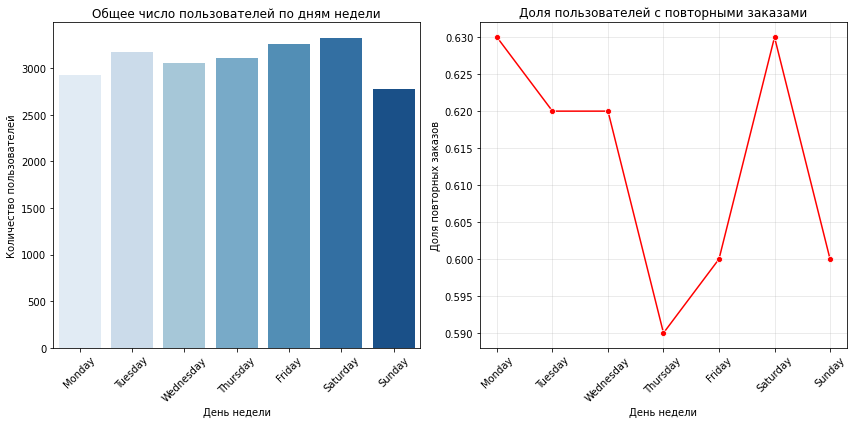

In [51]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.barplot(data=result, x='weekday_name', y='total_users', palette='Blues')
plt.title('Общее число пользователей по дням недели')
plt.ylabel('Количество пользователей')
plt.xlabel('День недели')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.lineplot(data=result, x='weekday_name', y='repeat_ratio', marker='o', color='red')
plt.title('Доля пользователей с повторными заказами')
plt.ylabel('Доля повторных заказов')
plt.xlabel('День недели')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Наибольшая доля вернувшихся пользователей в понедельник и в субботу.

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


In [52]:
def total_orders(total_orders):
    if 2 <= total_orders <= 4:
        return '2-4 заказа'
    elif total_orders >= 5:
        return 'от 5 и более заказов'

filtered = user_profiles_filtered[user_profiles_filtered['avg_days_since_prev'] >= 0].copy()
filtered['total_orders_group'] = filtered['total_orders'].apply(total_orders)
result = filtered.groupby('total_orders_group').agg(avg_days=('avg_days_since_prev', 'mean'),repeat_users=('is_two', 'sum')).reset_index()
result['avg_days'] = result['avg_days'].round(2)

result

,total_orders_group,avg_days,repeat_users
0,2-4 заказа,18.64,4702
1,от 5 и более заказов,8.89,5848


В сегменте `от 5 и более заказов` средний интервал между заказами 8.9 дней.  

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

In [72]:
interval_cols = ['avg_order_costs','avg_tickets_count', 'avg_days_since_prev']
cols = ['region','avg_order_costs','avg_tickets_count', 'avg_days_since_prev','service_name', 'genre_event', 'device']
user_profiles_filtered_correlation = user_profiles_filtered.drop(columns=['user_id'])
correlation_matrix = user_profiles_filtered_correlation.phik_matrix(interval_cols=interval_cols)
corr_with_orders = correlation_matrix.loc[cols, 'total_orders'].sort_values(ascending=False)
print(corr_with_orders)

avg_days_since_prev    0.510725
region                 0.410223
avg_tickets_count      0.290347
avg_order_costs        0.254385
device                 0.066900
service_name           0.000000
genre_event            0.000000
Name: total_orders, dtype: float64


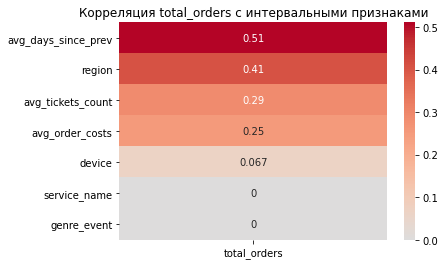

In [73]:
corr_df = corr_with_orders.to_frame()
plt.figure(figsize=(6, 4))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', center=0)
plt.title('Корреляция total_orders с интервальными признаками')
plt.show()

Наиболее связанные признаки с `total_orders` это среднее время между заказами, регион в котором прошло мероприятие, среднее количество билетов в заказе и средний чек заказа.

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

#### Вывод

Из базы данных через SQL запрос была получена информация из Яндекс Афиши. 

Был сформирован изначальный датафрейм `df` в котором было 290611 строк. 

Был предоставлен датасет `final_tickets_tenge_df.csv` с курсом тенге к рублю за 24 год.

Объединили два датафрейма в один `df_merged` для приведения всех цен к одной валюте - рублю. Была создана колонка `revenue_rub`.

Далее был исследован датафрейм `df_merged` на дубликаты и выбросы. Были замечены выбросы в колонке `revenue_rub`. Была проведена оптимизация датафрейма. 

После предобработки мы получили датафрейм `df_filtered` который уменьшился на 2825 строк.

Сотставили профиль каждого пользователя `user_profiles`, всего в выборке было 21854 пользователей. После фильтрации по количеству заказов пользователей стало 21638.

Доля пользователей, совершивших 2 и более заказа: 61.71
Доля пользователей, совершивших 5 и более заказов: 29.01

Признаки связанные с возвратом покупателя:
1. Тип приложения - пользователи совершившие заказ через `мобильное` приложение чаще возвращаются.
2. Регион проведения мероприятия - `Каменевский регион` и `Североярская область` являются наиболее популярным местом проведения мероприятий у вернувшихся пользователей.
3. Тип меропрития - наибольшее количество вернувшихся пользователей покупали билеты на концерты.
4. Название сервиса на котором приобрели билеты - `Билеты без проблем` и `Мой билет` являются наиболее популярными у вернувшихся пользователей.

Пользователи совершившие один заказ концентрируются в интервале от 400 до 800 рублей за заказ. 

Пользователи совершившие более 1 заказа концентрируются в интервале от 500 до 700 рублей за заказ.

Доля пользователей совершивших более 1 заказа в `Понедельник` и `Субботу` выше чем в другие дни недели.

Сильную корреляционную связь с количеством заказов имеют: среднее количество дней между заказами, регион проведения мероприятия и среднее количество билетов в заказе

#### Рекомендации

1. Необходимо обратить внимание на пользователей совершающих покупки через десктопное устройство.
2. Обратить внимание на другие регионы проведения мероприятий. 
3. Обратить внимание на другие типы мероприятий. Приложить больше маркенговых усилий для рекламы других мероприятий.
4. Обратить внимание на сервисы по продажам билетов. Прорекламировать другие сервисы или изменить ценовую политику, добавив скидки, программу лояльности и т.д.

### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**